In [1]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from codec import AutoEncoderND, pil_to_latent, latent_to_pil
from tft.wavelet import WPT3D, IWPT3D
from tft.utils import compand, decompand
from tft.transforms import RandomCrop3D

In [2]:
medmnist_types = ['organ', 'adrenal', 'fracture', 'nodule', 'synapse', 'vessel']
dataset_train = datasets.concatenate_datasets([datasets.load_dataset(f"danjacobellis/{type}mnist3d_64", split='train') for type in medmnist_types])
dataset_valid = datasets.concatenate_datasets([datasets.load_dataset(f"danjacobellis/{type}mnist3d_64", split='validation') for type in medmnist_types])

In [3]:
device = "cuda"
config = SimpleNamespace()
config.F = 8
config.latent_dim = 32
config.input_channels = 1
config.lightweight_encode = True
config.lightweight_decode = False
config.encoder_depth = 6
config.λ = 1.5e-1
config.ema_decay = 0.999
config.consistency_start = 0.05
config.consistency_loss = 1.0
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 6
config.progressive_sizes = [8*int(s) for s in np.linspace(1.5,2,10)**3]; print(config.progressive_sizes)
config.batch_size = 32
config.num_workers = 32
config.epochs = 600
config.total_steps = config.epochs * (dataset_train.num_rows // config.batch_size)
config.checkpoint = None

[24, 24, 32, 32, 40, 40, 48, 48, 56, 64]


In [4]:
model = AutoEncoderND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

33.887264 M parameters


In [5]:
import copy
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, student):
        for ema_p, student_p in zip(self.teacher.parameters(), student.parameters()):
            ema_p.copy_(ema_p * self.decay + student_p * (1 - self.decay))

In [6]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def pil_to_grid3d(img):
    x = torch.tensor(np.array(img))
    x = einops.rearrange(x, '(a y) (b z) c -> (a b c) y z', a=4, b=4, c=4)
    return x
    
def collate_fn(batch,epoch):
    rand_crop = RandomCrop3D(get_epoch_size(epoch))
    return torch.cat([
        rand_crop(pil_to_grid3d(sample['image']).unsqueeze(0).unsqueeze(0)) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [7]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []
consistency_losses = []

ema_helper = EMAHelper(model, decay=config.ema_decay)

global_step = 0
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        # Main model forward pass (additive noise)
        z = model.encode(x)
        z_noisy = model.quantize(z)  # noisy (training mode)
        x_hat = model.decode(z_noisy)

        # Reconstruction and rate loss
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate = model.quantize.compand(z).std().log2()
        rate_losses.append(rate.item())

        total_loss = mse_loss + config.λ * rate

        # EMA Latent Consistency Loss (only after certain training point)
        if global_step > config.consistency_start * config.total_steps:
            with torch.no_grad():
                z_teacher = ema_helper.teacher.encode(x)
                z_teacher = ema_helper.teacher.quantize.compand(z_teacher).round()
            consistency_loss = torch.nn.functional.mse_loss(
                model.quantize.compand(z), z_teacher
            ).log10()
            consistency_losses.append(consistency_loss.item())
            total_loss += config.consistency_loss * consistency_loss
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"Consistency: {consistency_loss:.4f}, LR: {learning_rates[-1]:.2g}")
        else:
            pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, "
                          f"LR: {learning_rates[-1]:.2g}")

        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # EMA update step after optimizer step
        ema_helper.update(model)

        global_step += 1

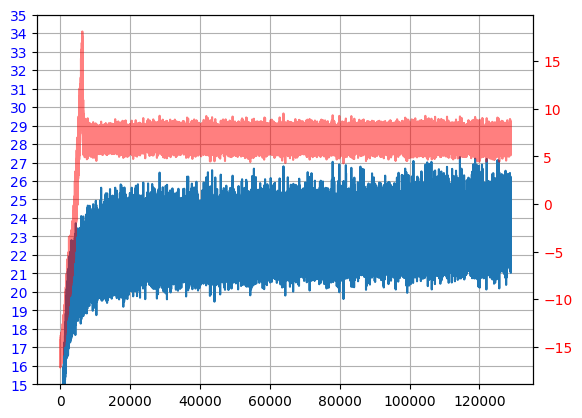

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

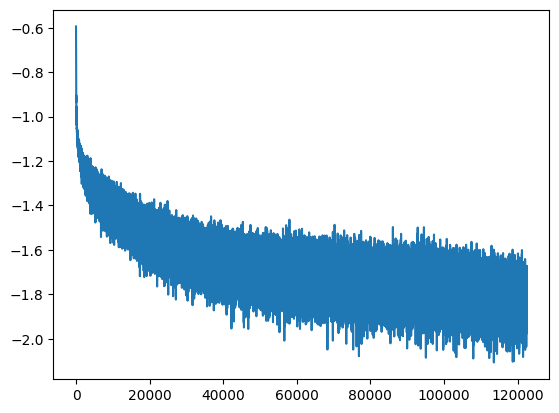

In [9]:
plt.plot(consistency_losses)

In [15]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../hf/dance/LF_m3d_f8c32_v1.0.pth')

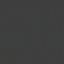

Compressed size: 2.00 KB
Compression ratio: 131.20x
Dimension reduction: 16.00x
PSNR: 20.22 dB


interactive(children=(IntSlider(value=31, description='slice_idx', max=63), Output()), _dom_classes=('widget-i…

In [11]:
from IPython.display import display, clear_output
from ipywidgets import interact

model.eval()
sample = dataset_valid[0]
x = pil_to_grid3d(sample['image']).unsqueeze(0).unsqueeze(0).to(device).to(torch.float) / 127.5 - 1.0
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()
latent = einops.rearrange(latent, 'b c d h w -> b (c d) h w').cpu()

webp = latent_to_pil(latent, n_bits=8, C=4)
display(webp[0])
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())

print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")

latent_decoded = pil_to_latent(webp, N=256, n_bits=8, C=4)
latent_decoded = einops.rearrange(latent_decoded, 'b (c d) h w -> b c d h w', d=8).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1, 1)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02

print(f"PSNR: {PSNR:.2f} dB")

original_volume = x[0,0].cpu().numpy()
reconstructed_volume = x_hat[0,0].cpu().numpy()

def show_slices(slice_idx):
    clear_output(wait=True)
    orig_slice = ToPILImage()(original_volume[slice_idx]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS)
    recon_slice = ToPILImage()(reconstructed_volume[slice_idx]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS)
    display(orig_slice)
    display(recon_slice)

interact(show_slices, slice_idx=(0, original_volume.shape[0]-1, 1));

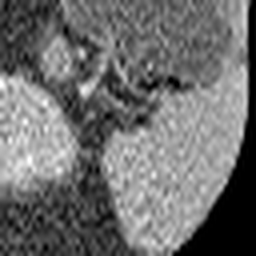

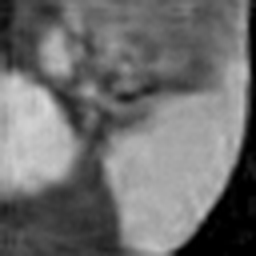

In [13]:
display(ToPILImage()(original_volume[31]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS))
display(ToPILImage()(reconstructed_volume[31]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS))

bpc: 1.702098288814006, cr: 75.20129762258811


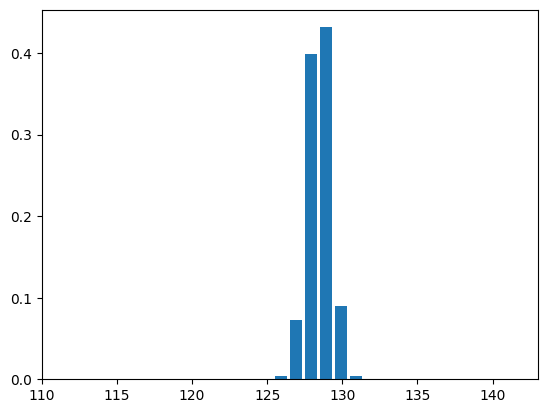

In [14]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([110,143])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")